In [ ]:
import scprep
scprep.io.download.download_google_drive('1VuddKA7Xa23NAFKvRUmtuND16eEMHL9z', '/content/r_packages.tar.gz')
!tar xzf /content/r_packages.tar.gz && rm /content/r_packages.tar.gz
!apt-get install -yqq libgsl-dev=2.4+dfsg-6
!echo "R_LIBS_USER='/content/.r_packages'" >> ~/.Renviron
!R -e "BiocManager::install('splatter')"

In [1]:
# %load /home/dan/.jupyter/firstcell.py
%load_ext autoreload
%autoreload 2

%matplotlib inline
import matplotlib.pyplot as plt
import matplotlib as mpl
import seaborn as sns

font = {'size'   : 12}
mpl.rc('font', **font)

import numpy as np
import pandas as pd
from scipy import stats

import scprep
import phate
import meld
import magic
import graphtools as gt
from sklearn.decomposition import PCA
from sklearn import cluster
from sklearn.manifold import TSNE
import umap
import time

from scipy import sparse
from scipy.spatial.distance import pdist, squareform

## Generate Synthetic Data with Known Ground Truth

### Introduction to Splatter

Splatter, [Zappia L, et al. Genome Biology. 2017](https://doi.org/10.1186/s13059-017-1305-0), is a tool for simulating single-cell RNA-sequencing data with a known topology. Splatter has two main modes: "paths" and "groups." Because we're interested in generating data with a known trajectory structure, we are going to use the `paths` mode.

Splatter has a bunch of other parameters you can choose from, feel free to play around with the various options.


#### Generating simulated data

Splatter is only implemented in R. Fortunately, we provide a wrapper in the `scprep.run` module. You can call Splatter from Python using [`scprep.run.SplatSimulate()`](https://scprep.readthedocs.io/en/stable/reference.html#scprep.run.SplatSimulate).

In [207]:
# Run Splatter

# You can easily change the number of paths and cells here
n_groups = 5
cells_per_group = 1000

# Splatter returns a `dict` objbect that contains a bunch of useful information
results = scprep.run.SplatSimulate(
                        method='paths', 
                        batch_cells=n_groups * cells_per_group, 
#                        group_prob=np.tile(1/n_paths, n_paths), 
                        n_genes=5000,
                        de_down_prob=0,
#                        path_from=[0,0,0],
#                        mean_shape=1,
#                        de_fac_loc=0.1,
#                        path_nonlinear_prob=0.5,
                        seed=0)

R[write to console]: Getting parameters...
R[write to console]: Creating simulation object...
R[write to console]: Simulating library sizes...
R[write to console]: Simulating gene means...
R[write to console]: Simulating path endpoints...
R[write to console]: Simulating path steps...
R[write to console]: Simulating BCV...
R[write to console]: Simulating counts...
R[write to console]: Simulating dropout (if needed)...
R[write to console]: Done!


Let's check what we can find in this `results` dictionary. Note, you can find explanations of what each key refers to by checking the `returns` section of the `SplatSimulate` docstring or consulting https://scprep.readthedocs.io/en/stable/reference.html#scprep.run.SplatSimulate.

In [195]:
results.keys()

dict_keys(['counts', 'group', 'step', 'batch', 'exp_lib_size', 'base_gene_mean', 'outlier_factor', 'batch_cell_means', 'base_cell_means', 'bcv', 'cell_means', 'true_counts', 'dropout', 'de_fac_1', 'sigma_fac_1'])

There's a lot of organizational stuff happening in the next code block. The key idea is that we want to grab three pieces of information from `results`:
* `counts` - simulated expression counts
* `group` - the group or path the cell belongs to
* `step` - how far along the path each cell is

We're putting `counts` into one DataFrame and `group` & `step` in a separate DataFrame. Then we do some manipulation of the `step` vector so it increases monotonically (as opposed to restarting at 0 at the beginning of each path). Finally we change the name of the `Index` of `data` and `metadata` and preprocess the data.

In [208]:
# Put counts data in DataFrame
data = pd.DataFrame(results['true_counts'])

# Put metadata in a DataFrame
metadata = pd.DataFrame([results['step'], results['group']], index=['step', 'group']).T
metadata = metadata.astype({'step': int}) # These are strings by default, but we want ints

## Adjusting the 'step' vector to monotonically increase
#p1_mask = metadata['group'] == 1
#metadata.loc[p1_mask, 'step'] = 100 - metadata.loc[p1_mask, 'step']
#p23_mask = np.isin(metadata['group'], [2,3])
#metadata.loc[p23_mask, 'step'] = 100 + metadata.loc[p23_mask, 'step']

# Change DataFrame index names to be a little nicer
new_index = pd.Index(['cell_{}'.format(i) for i in range(metadata.shape[0])])
data.index = new_index
metadata.index = new_index

### Library-size normalize and sqrt transform
#data = scprep.normalize.library_size_normalize(data)
#data = scprep.transform.sqrt(data)

#### Visualizing the data

Splatter is designed to generate data that can be easily visualized using PCA. Try to visualize the data using other tools from our visualization module.

In [209]:
data_pca = scprep.reduce.pca(data)

Plot the data using `scprep.plot.scatter2d()`.

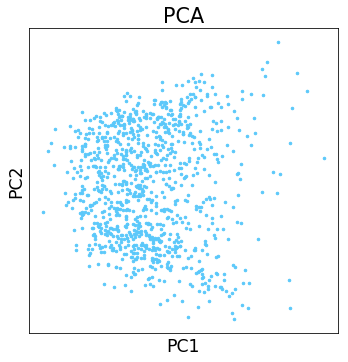

In [210]:
ax = scprep.plot.scatter2d(data_pca, color='#5ac8fa',
                      ticks=None, title='PCA', 
                      label_prefix='PC',
                      figsize=(5,5.2))

ax.figure.tight_layout()

#### Simulating dropout

We generally think of dropout in scRNA-seq data as coming from undersampling of RNA molecules. There is some probability $p$ that a given molecule is captured through reverse transcription, and each of the $n$ mRNA molecules of a particular gene has an equal and independent probability of being sampled. These assumptions lead us to the binomial model for sampling. 

A binomial distribution has two parameters, $n$ and $p$. $p$ represents the chance of success on each of $n$ chances. Here, "success" would be defined as the successful reverse transcription of a given mRNA molecule. 

We can simulate dropout in scRNA-seq from our ground-truth `counts` by parameterizing a binomial distribution for each gene with $n$ equal to the number of true counts of a given gene in a given cell. To draw from such a binomial, we can use `np.random.binomial`.

In [211]:
data_dropout = np.random.binomial(data, .1, data.shape)

In [212]:
data_dropout = scprep.normalize.library_size_normalize(data_dropout)
data_dropout = scprep.transform.sqrt(data_dropout)

In [213]:
data_pca = scprep.reduce.pca(data)

In [214]:
data_magic = magic.MAGIC(t=4).fit_transform(data_dropout)

Calculating MAGIC...
  Running MAGIC on 1000 cells and 5000 genes.
  Calculating graph and diffusion operator...
    Calculating PCA...


/home/dan/.local/lib/python3.7/site-packages/magic/magic.py:376: UserWarning: Input matrix contains unexpressed genes. Please remove them prior to running MAGIC.
  warnings.warn("Input matrix contains unexpressed genes. "


    Calculated PCA in 1.15 seconds.
    Calculating KNN search...
    Calculated KNN search in 0.16 seconds.
    Calculating affinities...
    Calculated affinities in 0.20 seconds.
  Calculated graph and diffusion operator in 1.53 seconds.
  Calculating imputation...
  Calculated imputation in 0.15 seconds.
Calculated MAGIC in 2.10 seconds.


In [215]:
ix = np.argmax(results['de_fac_1'])

In [216]:
results['sigma_fac_1'][ix]

0.0

In [217]:
results['de_fac_1'][ix]

4.473420177497581

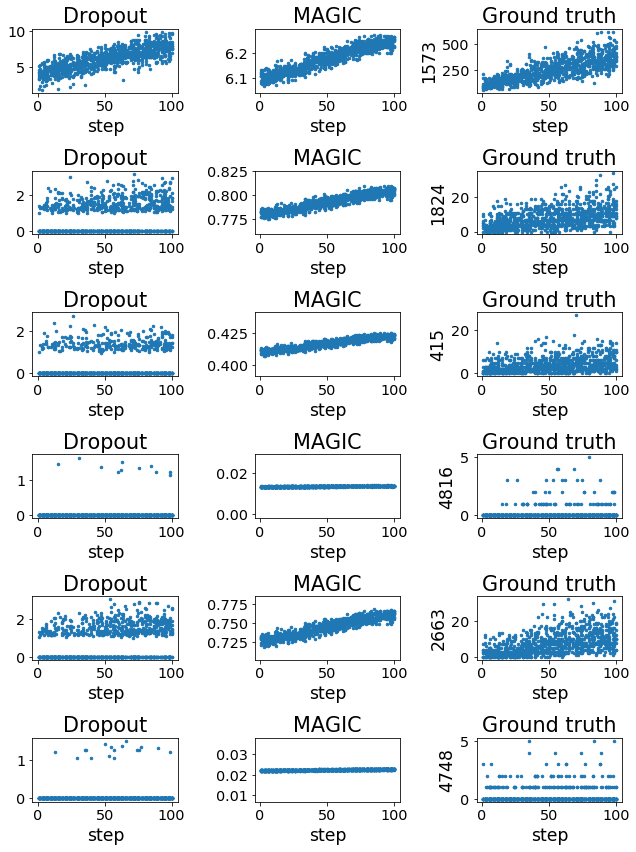

In [218]:
fig, axes = plt.subplots(6,3, figsize=(3*3, 6*2))

for i, r_axes in enumerate(axes):
    ix = np.argsort(results['de_fac_1'])[::-1][i]
    scprep.plot.scatter(metadata['step'], data_dropout[:,ix], title='Dropout', ax=r_axes[0])
    scprep.plot.scatter(metadata['step'], data_magic[:,ix], title='MAGIC', ax=r_axes[1])
    scprep.plot.scatter(metadata['step'], data.iloc[:,ix], title='Ground truth', ax=r_axes[2])  
    
fig.tight_layout()